In [36]:
import numpy as np
import pandas as pd
import io
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import joblib

**IMPORTACION DEL DATA SET**

In [58]:
archivo= ('csv/diabetes_dataset.csv')

In [59]:
data = pd.read_csv(archivo)

In [5]:
## outcome para variables de todo el data set en base a las siguientes condiciones y examenes:
data['Outcome'] = ((data['Fasting_Blood_Glucose'] >= 126) | (data['HbA1c'] > 6.5)).astype('int64')

In [ ]:
## out come adapatado a las variables que se puede obtener teniendo en cuenta el historial familiar 
data['Outcome'] = (
    (data['BMI'] > 25) |
    ((data['Waist_Circumference'] > 101) & (data['Sex'] == 'Male')) |
    ((data['Waist_Circumference'] > 88) & (data['Sex'] == 'Female')) |
    (data['Family_History_of_Diabetes'] == 1) |
    (data['Physical_Activity_Level'] == 'low')
).astype(int)


In [60]:
## out come adapatado a las variables que se puede obtener sin historial familiar
data['Outcome'] = (
    (data['BMI'] > 25) |
    ((data['Waist_Circumference'] > 101) & (data['Sex'] == 'Male')) |
    ((data['Waist_Circumference'] > 88) & (data['Sex'] == 'Female')) |
    (data['Physical_Activity_Level'] == 'low')
).astype(int)


In [61]:
data.drop(columns=['Unnamed: 0'], inplace=True)

**Lectura del DATASET**

In [41]:
data.head()

,Age,Sex,Ethnicity,BMI,Waist_Circumference,Fasting_Blood_Glucose,HbA1c,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Cholesterol_Total,...,Cholesterol_LDL,GGT,Serum_Urate,Physical_Activity_Level,Dietary_Intake_Calories,Alcohol_Consumption,Smoking_Status,Family_History_of_Diabetes,Previous_Gestational_Diabetes,Outcome
0,58,Female,White,35.8,83.4,123.9,10.9,152,114,197.8,...,99.2,37.5,7.2,Moderate,1538,Moderate,Never,0,1,1
1,48,Male,Asian,24.1,71.4,183.7,12.8,103,91,261.6,...,146.4,88.5,6.1,Moderate,2653,Moderate,Current,0,1,0
2,34,Female,Black,25.0,113.8,142.0,14.5,179,104,261.0,...,164.1,56.2,6.9,Low,1684,Heavy,Former,1,0,1
3,62,Male,Asian,32.7,100.4,167.4,8.8,176,118,183.4,...,84.0,34.4,5.4,Low,3796,Moderate,Never,1,0,1
4,27,Female,Asian,33.5,110.8,146.4,7.1,122,97,203.2,...,92.8,81.9,7.4,Moderate,3161,Heavy,Current,0,0,1


In [10]:
data.shape

(10000, 21)

In [220]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            10000 non-null  int64  
 1   Sex                            10000 non-null  object 
 2   Ethnicity                      10000 non-null  object 
 3   BMI                            10000 non-null  float64
 4   Waist_Circumference            10000 non-null  float64
 5   Fasting_Blood_Glucose          10000 non-null  float64
 6   HbA1c                          10000 non-null  float64
 7   Blood_Pressure_Systolic        10000 non-null  int64  
 8   Blood_Pressure_Diastolic       10000 non-null  int64  
 9   Cholesterol_Total              10000 non-null  float64
 10  Cholesterol_HDL                10000 non-null  float64
 11  Cholesterol_LDL                10000 non-null  float64
 12  GGT                            10000 non-null  

In [221]:
data.dtypes

Age                                int64
Sex                               object
Ethnicity                         object
BMI                              float64
Waist_Circumference              float64
Fasting_Blood_Glucose            float64
HbA1c                            float64
Blood_Pressure_Systolic            int64
Blood_Pressure_Diastolic           int64
Cholesterol_Total                float64
Cholesterol_HDL                  float64
Cholesterol_LDL                  float64
GGT                              float64
Serum_Urate                      float64
Physical_Activity_Level           object
Dietary_Intake_Calories            int64
Alcohol_Consumption               object
Smoking_Status                    object
Family_History_of_Diabetes         int64
Previous_Gestational_Diabetes      int64
Outcome                            int32
dtype: object

In [180]:
data.describe()

,Age,BMI,Waist_Circumference,Fasting_Blood_Glucose,HbA1c,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Cholesterol_Total,Cholesterol_HDL,Cholesterol_LDL,GGT,Serum_Urate,Dietary_Intake_Calories,Family_History_of_Diabetes,Previous_Gestational_Diabetes,Outcome
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,44.620400,29.418150,94.79707,134.776210,9.507510,134.163700,89.558700,225.165540,55.019340,134.35377,55.16822,5.503430,2742.481900,0.507000,0.516500,0.882500
std,14.343489,6.170866,14.38329,37.633544,3.176421,26.110317,17.237792,42.963744,14.537371,37.50238,25.88180,1.455091,716.643803,0.499976,0.499753,0.322031
min,20.000000,18.500000,70.00000,70.000000,4.000000,90.000000,60.000000,150.000000,30.000000,70.00000,10.00000,3.000000,1500.000000,0.000000,0.000000,0.000000
25%,32.000000,24.100000,82.20000,102.175000,6.800000,112.000000,75.000000,187.875000,42.300000,101.67500,32.60000,4.200000,2129.000000,0.000000,0.000000,1.000000
50%,45.000000,29.500000,94.90000,134.500000,9.500000,134.000000,89.000000,225.500000,55.200000,134.40000,55.45000,5.500000,2727.000000,1.000000,1.000000,1.000000
75%,57.000000,34.700000,107.00000,167.800000,12.300000,157.000000,105.000000,262.400000,67.900000,166.40000,77.50000,6.800000,3368.000000,1.000000,1.000000,1.000000
max,69.000000,40.000000,120.00000,200.000000,15.000000,179.000000,119.000000,300.000000,80.000000,200.00000,100.00000,8.000000,3999.000000,1.000000,1.000000,1.000000


**Estado de la data**

In [11]:
# numero de valores faltantes por columna
data.isnull().sum()

Age                                 0
Sex                                 0
Ethnicity                           0
BMI                                 0
Waist_Circumference                 0
Fasting_Blood_Glucose               0
HbA1c                               0
Blood_Pressure_Systolic             0
Blood_Pressure_Diastolic            0
Cholesterol_Total                   0
Cholesterol_HDL                     0
Cholesterol_LDL                     0
GGT                                 0
Serum_Urate                         0
Physical_Activity_Level             0
Dietary_Intake_Calories             0
Alcohol_Consumption              3320
Smoking_Status                      0
Family_History_of_Diabetes          0
Previous_Gestational_Diabetes       0
Outcome                             0
dtype: int64

In [12]:
## porcentaje de valores nulos
data.isna().sum()/len(data)*100

Age                               0.0
Sex                               0.0
Ethnicity                         0.0
BMI                               0.0
Waist_Circumference               0.0
Fasting_Blood_Glucose             0.0
HbA1c                             0.0
Blood_Pressure_Systolic           0.0
Blood_Pressure_Diastolic          0.0
Cholesterol_Total                 0.0
Cholesterol_HDL                   0.0
Cholesterol_LDL                   0.0
GGT                               0.0
Serum_Urate                       0.0
Physical_Activity_Level           0.0
Dietary_Intake_Calories           0.0
Alcohol_Consumption              33.2
Smoking_Status                    0.0
Family_History_of_Diabetes        0.0
Previous_Gestational_Diabetes     0.0
Outcome                           0.0
dtype: float64

In [13]:
## datos duplicados
data.duplicated().sum()

0

In [224]:
## valores imcompletos
data.isnull().any()

Age                              False
Sex                              False
Ethnicity                        False
BMI                              False
Waist_Circumference              False
Fasting_Blood_Glucose            False
HbA1c                            False
Blood_Pressure_Systolic          False
Blood_Pressure_Diastolic         False
Cholesterol_Total                False
Cholesterol_HDL                  False
Cholesterol_LDL                  False
GGT                              False
Serum_Urate                      False
Physical_Activity_Level          False
Dietary_Intake_Calories          False
Alcohol_Consumption               True
Smoking_Status                   False
Family_History_of_Diabetes       False
Previous_Gestational_Diabetes    False
Outcome                          False
dtype: bool

In [14]:
## valores unicos
data.nunique()

Age                                50
Sex                                 2
Ethnicity                           4
BMI                               216
Waist_Circumference               501
Fasting_Blood_Glucose            1301
HbA1c                             111
Blood_Pressure_Systolic            90
Blood_Pressure_Diastolic           60
Cholesterol_Total                1499
Cholesterol_HDL                   501
Cholesterol_LDL                  1301
GGT                               901
Serum_Urate                        51
Physical_Activity_Level             3
Dietary_Intake_Calories          2451
Alcohol_Consumption                 2
Smoking_Status                      3
Family_History_of_Diabetes          2
Previous_Gestational_Diabetes       2
Outcome                             2
dtype: int64

**Prepocesamiento**

In [62]:
# remplazo por la moda en la columna 'Alcohol_Consumption'
most_common = data['Alcohol_Consumption'].mode()[0]
data['Alcohol_Consumption'].fillna(most_common, inplace=True)

C:\Users\Jonna\AppData\Local\Temp\ipykernel_27256\3871047725.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Alcohol_Consumption'].fillna(most_common, inplace=True)


In [63]:
# visualizacion de los datos cambiados
data['Alcohol_Consumption'].head()

0    Moderate
1    Moderate
2       Heavy
3    Moderate
4       Heavy
Name: Alcohol_Consumption, dtype: object

In [64]:
# agrupamiento por rango de edad
bins = [0, 19, 29, 39, 49, 59, 69, 79, float('inf')]
labels = ['-20', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
data['Age Group'] = pd.cut(data['Age'], bins=bins, labels=labels, right=True)

In [65]:
# visualizacion de la distribucion de edad
data['Age Group'].head()

0    50-59
1    40-49
2    30-39
3    60-69
4    20-29
Name: Age Group, dtype: category
Categories (8, object): ['-20' < '20-29' < '30-39' < '40-49' < '50-59' < '60-69' < '70-79' < '80+']

In [66]:
## datos completa
data.head()

,Age,Sex,Ethnicity,BMI,Waist_Circumference,Fasting_Blood_Glucose,HbA1c,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Cholesterol_Total,...,GGT,Serum_Urate,Physical_Activity_Level,Dietary_Intake_Calories,Alcohol_Consumption,Smoking_Status,Family_History_of_Diabetes,Previous_Gestational_Diabetes,Outcome,Age Group
0,58,Female,White,35.8,83.4,123.9,10.9,152,114,197.8,...,37.5,7.2,Moderate,1538,Moderate,Never,0,1,1,50-59
1,48,Male,Asian,24.1,71.4,183.7,12.8,103,91,261.6,...,88.5,6.1,Moderate,2653,Moderate,Current,0,1,0,40-49
2,34,Female,Black,25.0,113.8,142.0,14.5,179,104,261.0,...,56.2,6.9,Low,1684,Heavy,Former,1,0,1,30-39
3,62,Male,Asian,32.7,100.4,167.4,8.8,176,118,183.4,...,34.4,5.4,Low,3796,Moderate,Never,1,0,1,60-69
4,27,Female,Asian,33.5,110.8,146.4,7.1,122,97,203.2,...,81.9,7.4,Moderate,3161,Heavy,Current,0,0,1,20-29


<Figure size 1000x600 with 0 Axes>

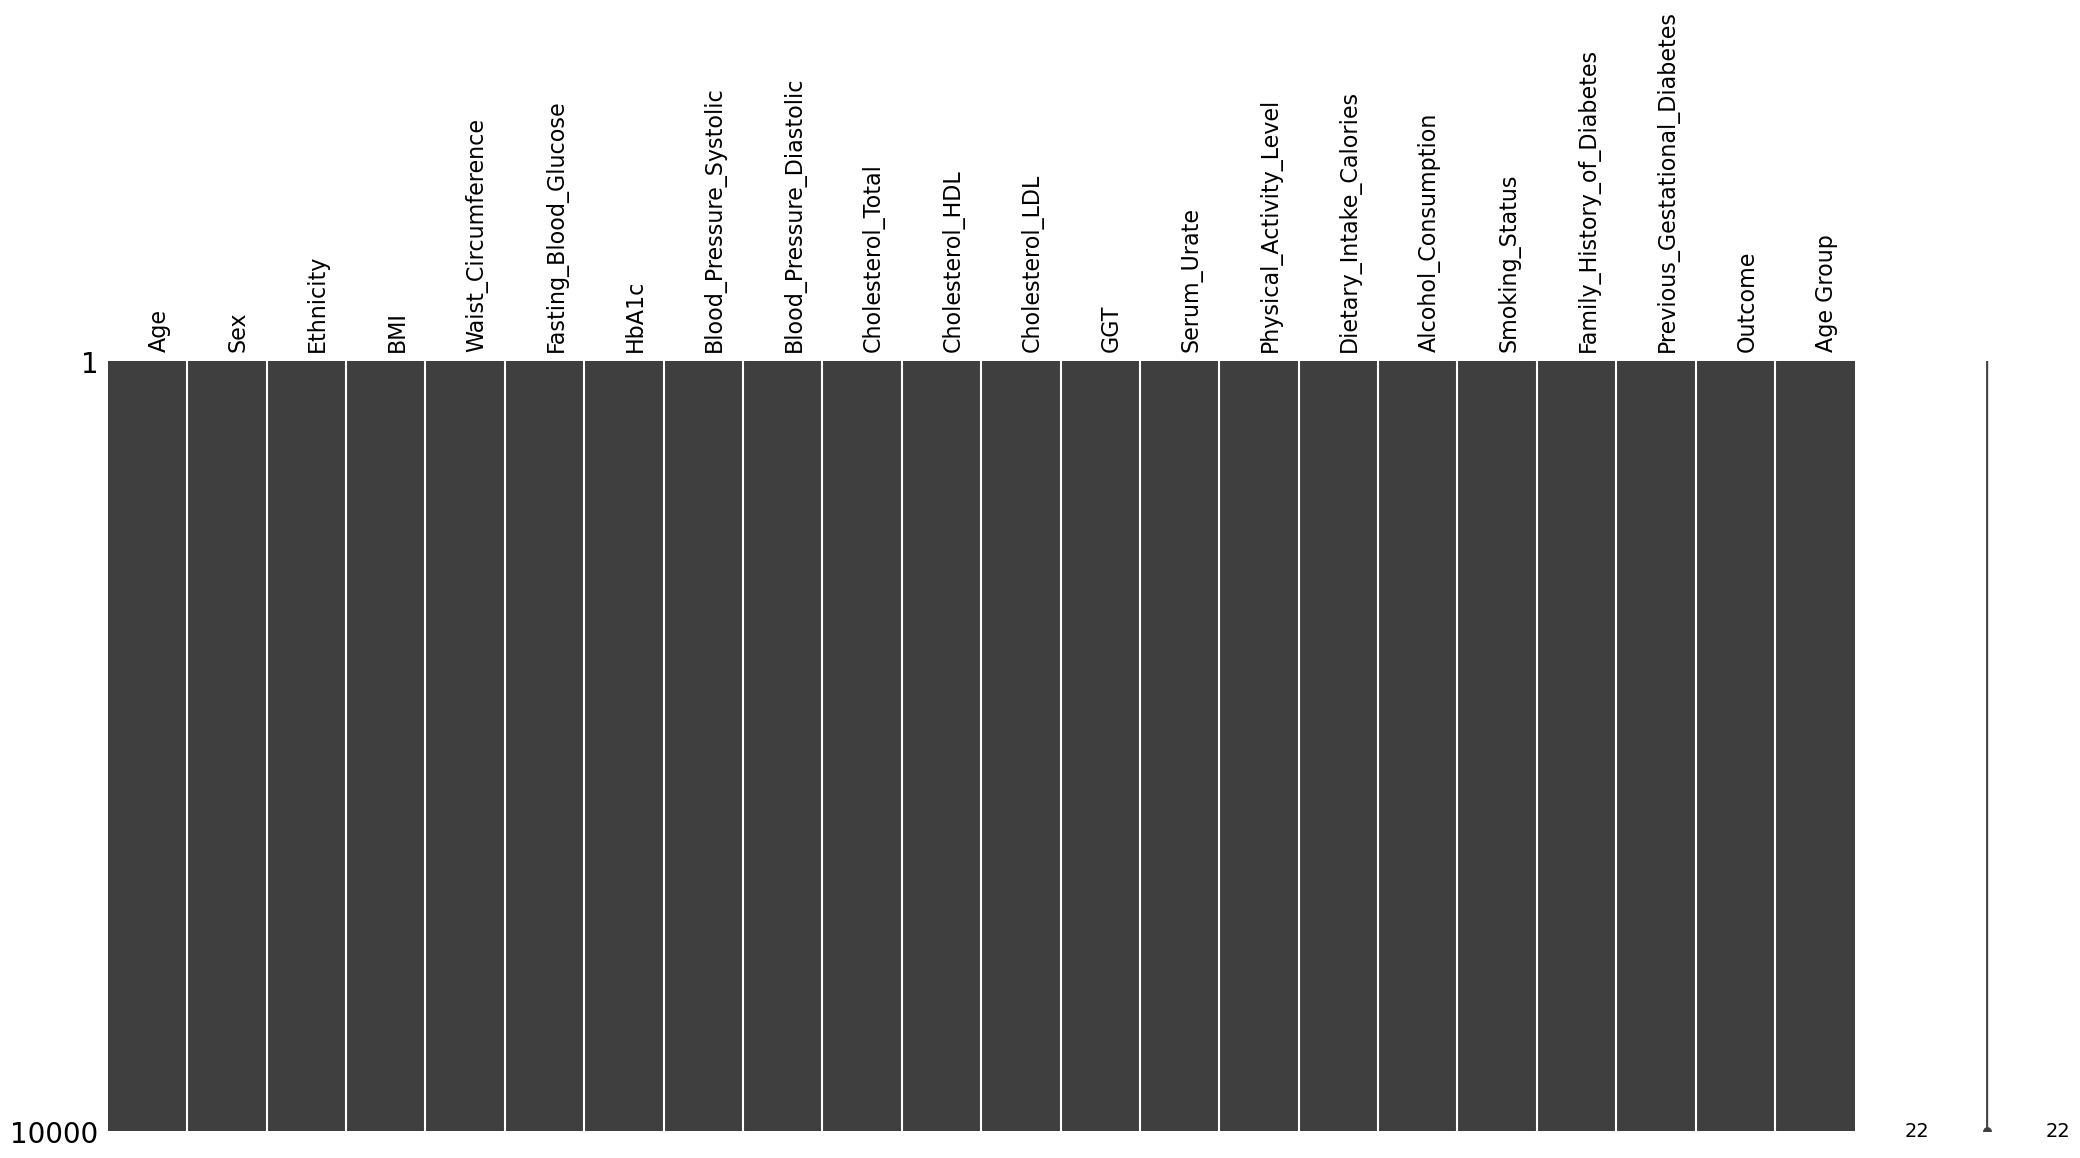

In [67]:
plt.figure(figsize=(10, 6))
msno.matrix(data)
plt.xticks(rotation=90)
plt.show()

In [152]:
## guardar el data en formato csv
data.to_csv('csv/diabetes_dataset_modificado.csv', index=False)

**Separacion de variables**

In [68]:
# separacion de varaibles numericas y categoricas
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

**VISUALIZACION DE LA DATA**

C:\Users\Jonna\AppData\Local\Temp\ipykernel_12256\2557625634.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


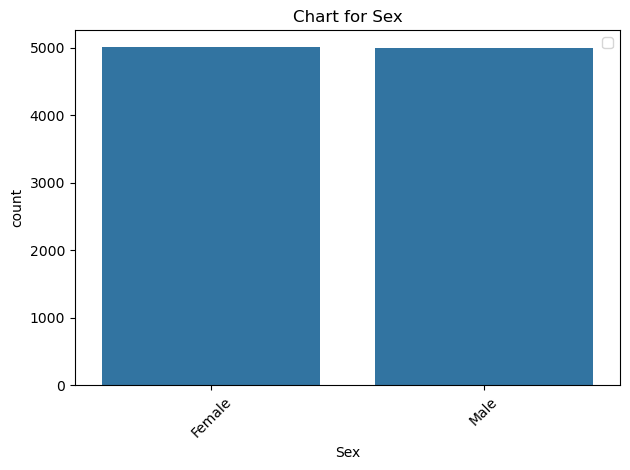

C:\Users\Jonna\AppData\Local\Temp\ipykernel_12256\2557625634.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


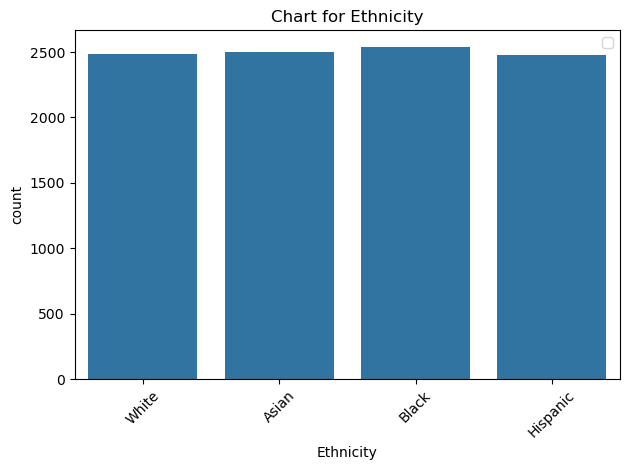

C:\Users\Jonna\AppData\Local\Temp\ipykernel_12256\2557625634.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


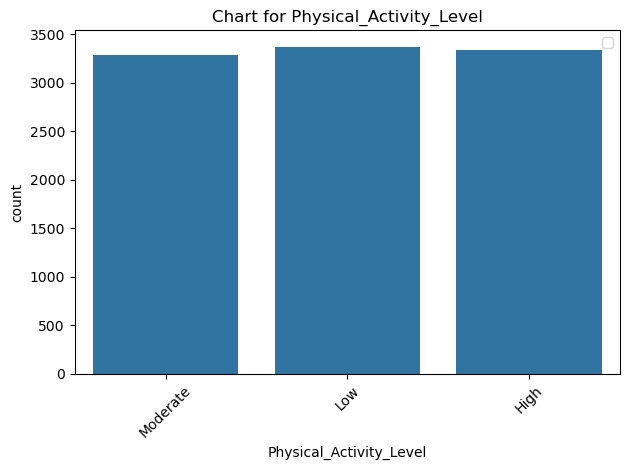

C:\Users\Jonna\AppData\Local\Temp\ipykernel_12256\2557625634.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


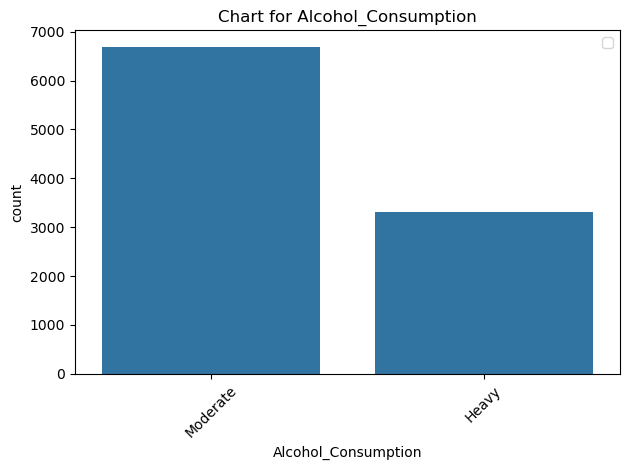

C:\Users\Jonna\AppData\Local\Temp\ipykernel_12256\2557625634.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


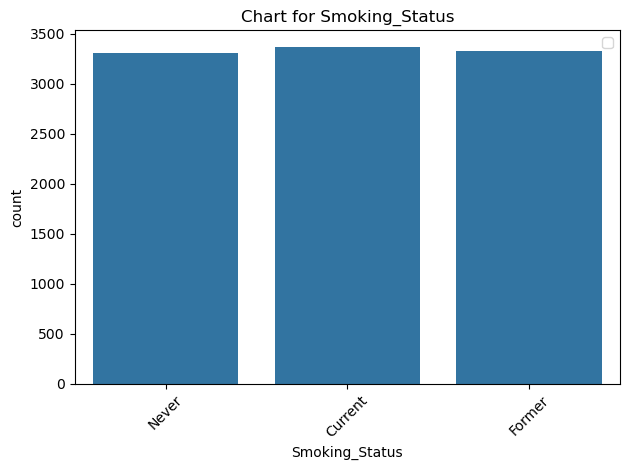

C:\Users\Jonna\AppData\Local\Temp\ipykernel_12256\2557625634.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


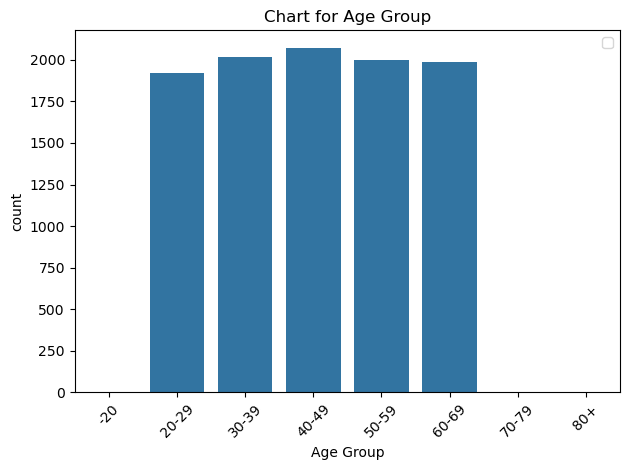

In [232]:
# Create bar plots
for col in categorical_cols:  
    sns.countplot(x=col, data=data)
    plt.title(f"Chart for {col}") 
    plt.xticks(rotation=45)  
    plt.legend()
    plt.tight_layout()
    plt.show()

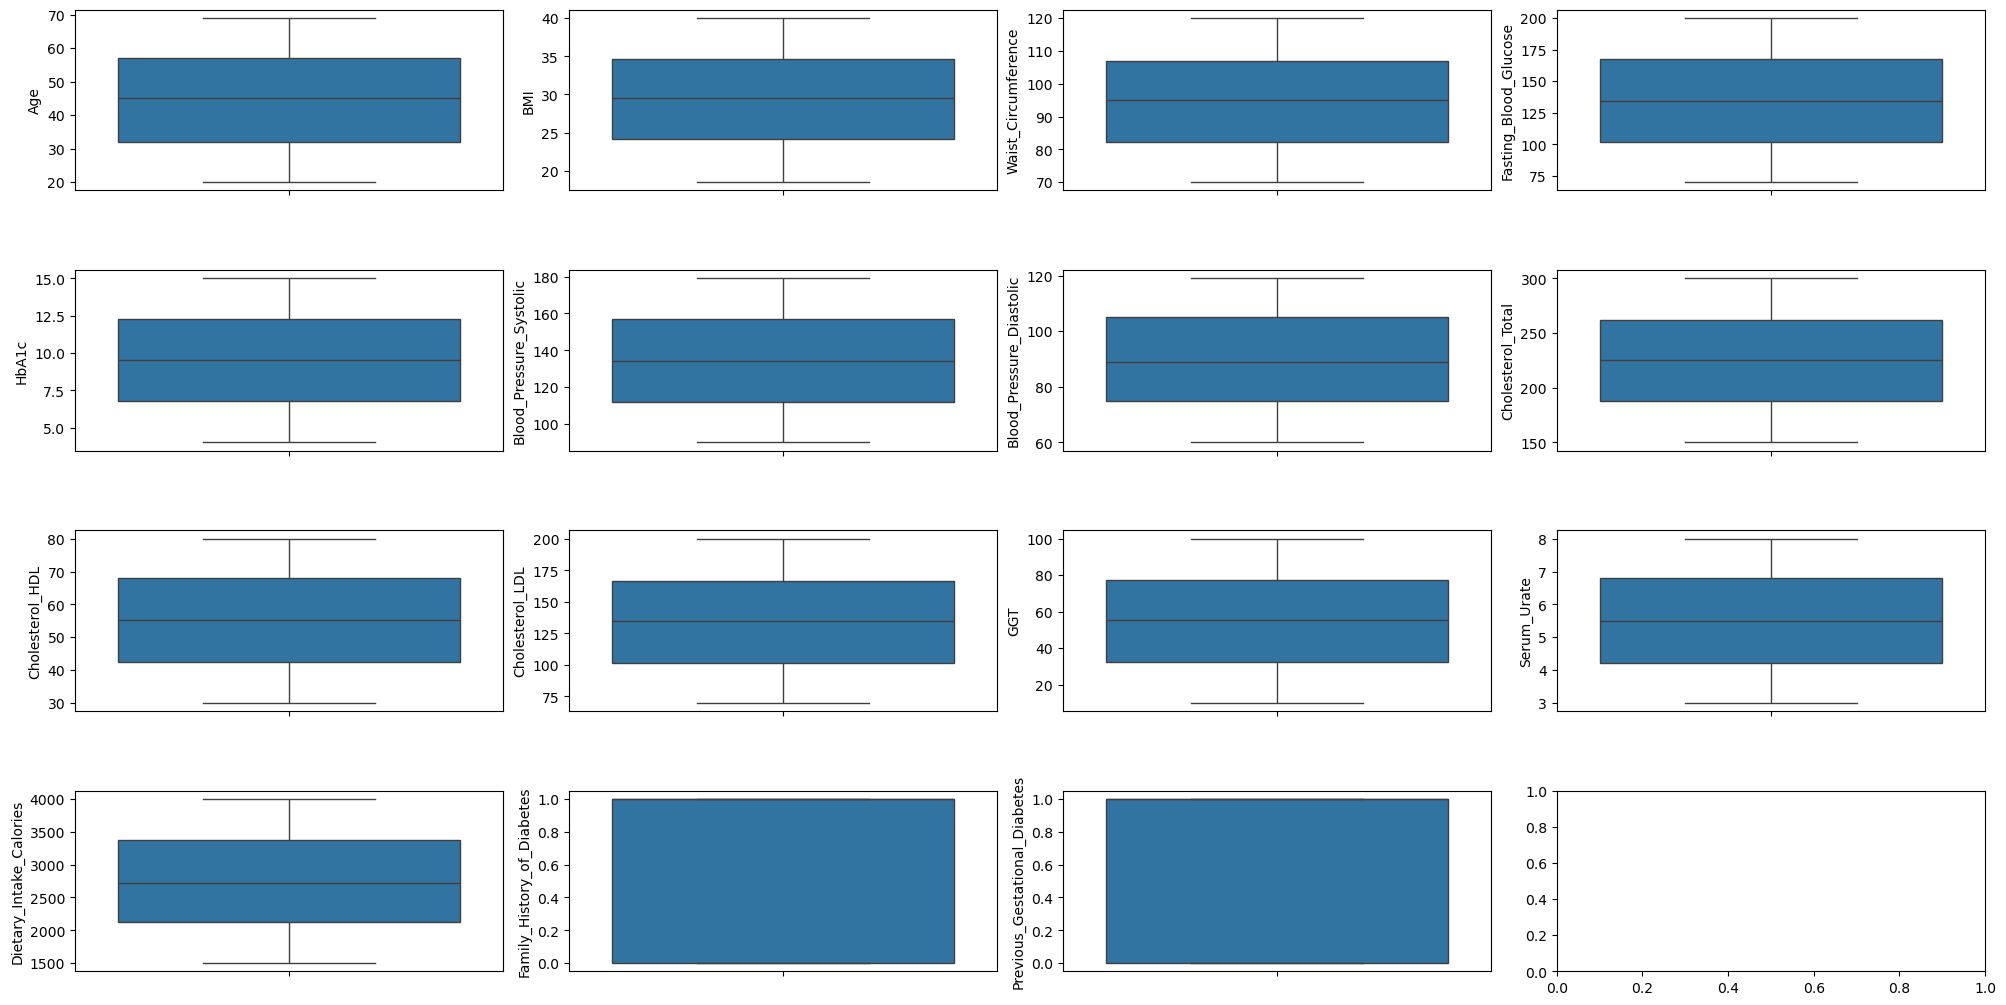

In [233]:
# graficos de boc plots
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20, 10))
ax = ax.flatten()

for index, col in enumerate(numeric_cols):
    sns.boxplot(y=col, data=data, ax=ax[index])

plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.show()

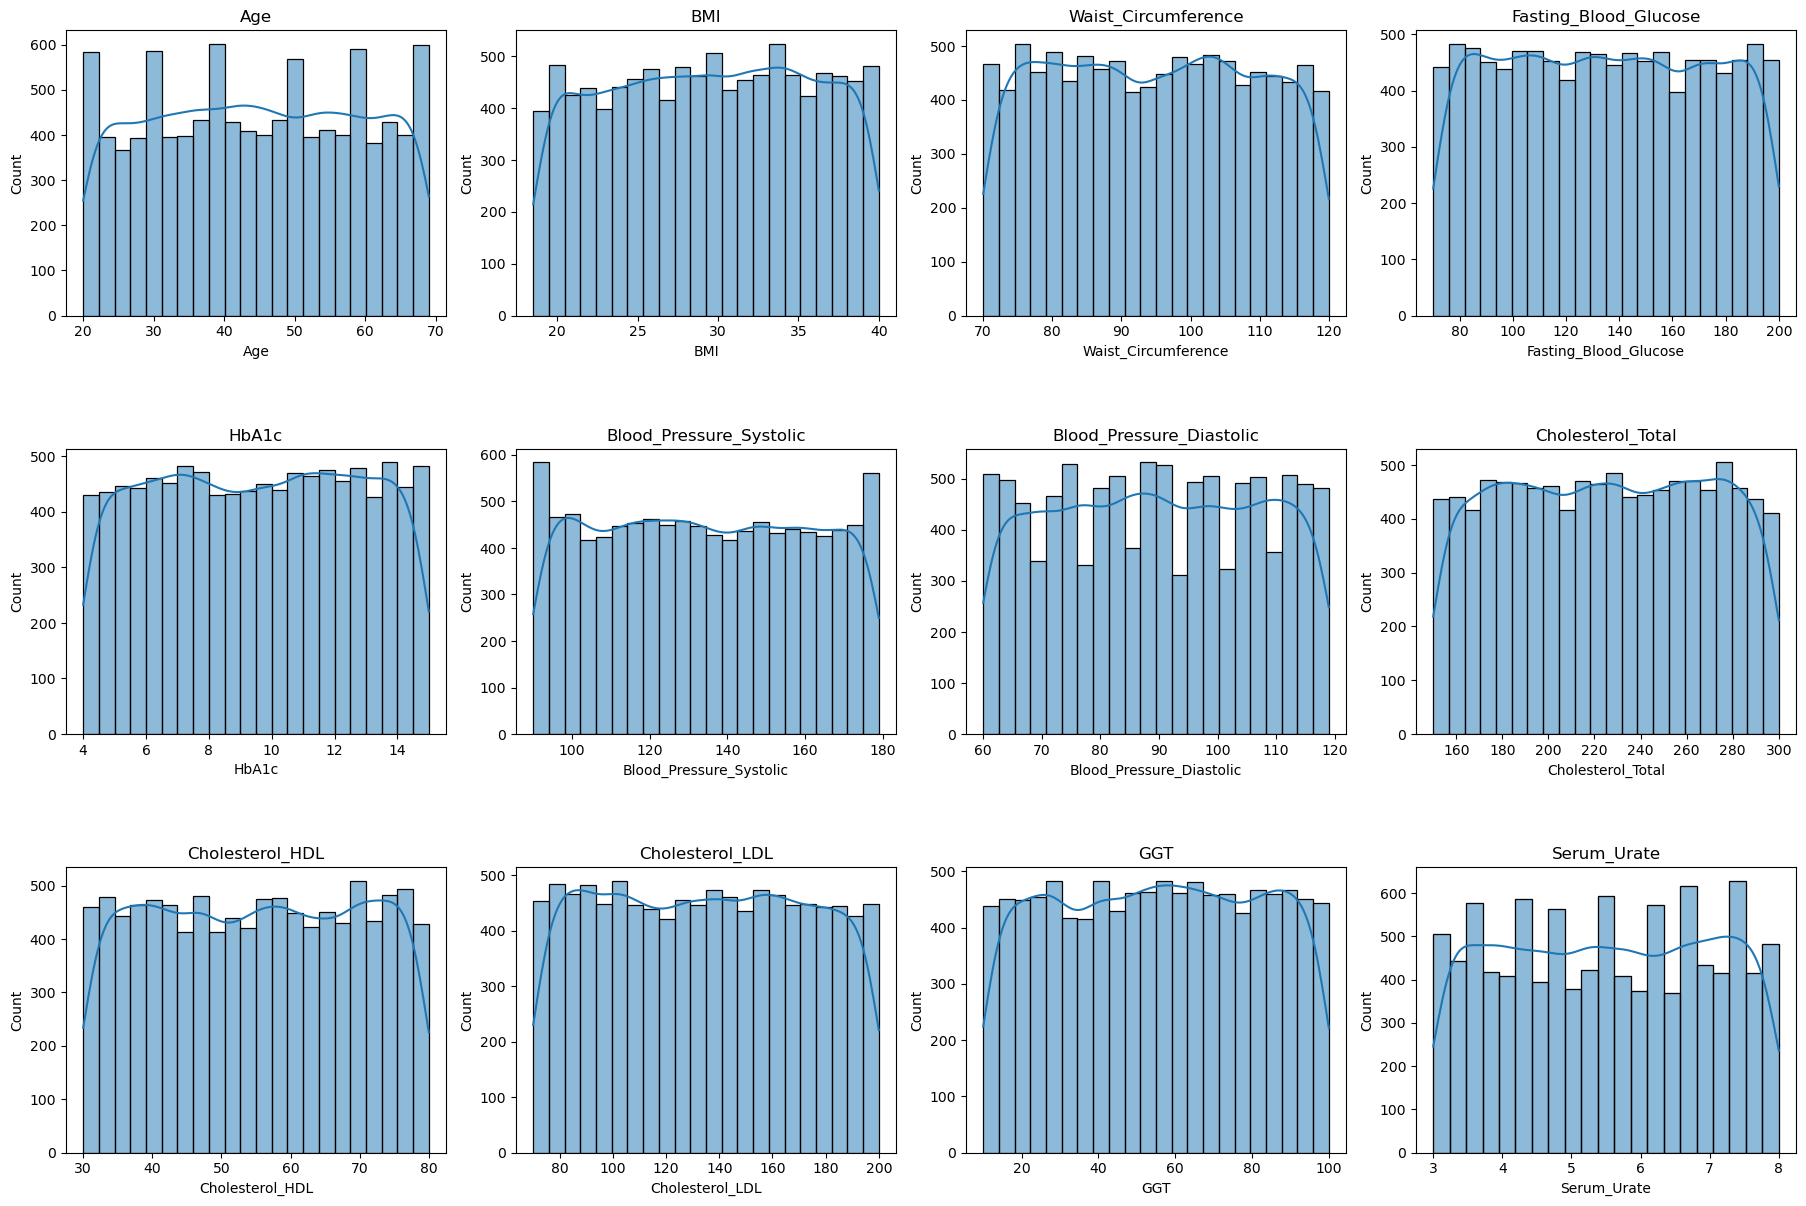

In [234]:
#graficos de histograma
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(18,12))
ax = ax.flatten()
index = 0

for col, value in data.select_dtypes(include=['int64', 'float64']).items():
    if col != 'type':
        if index >= len(ax):  
            break
        sns.histplot(value, ax=ax[index], kde=True)
        ax[index].set_title(col)
        index += 1

plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

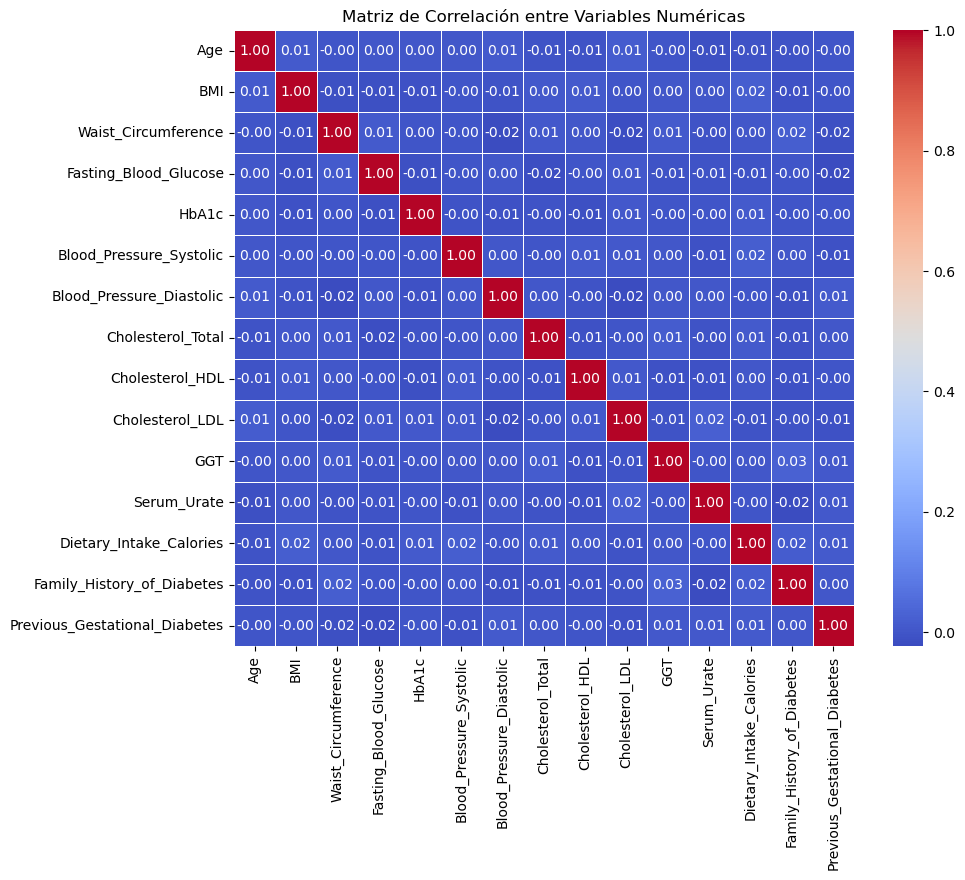

In [69]:
# Calcular la matriz de correlación
corr_matrix = data[numeric_cols].corr()
# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=ax)
ax.set_title("Matriz de Correlación entre Variables Numéricas")
plt.show()

C:\Users\Jonna\AppData\Local\Temp\ipykernel_12256\2327214971.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


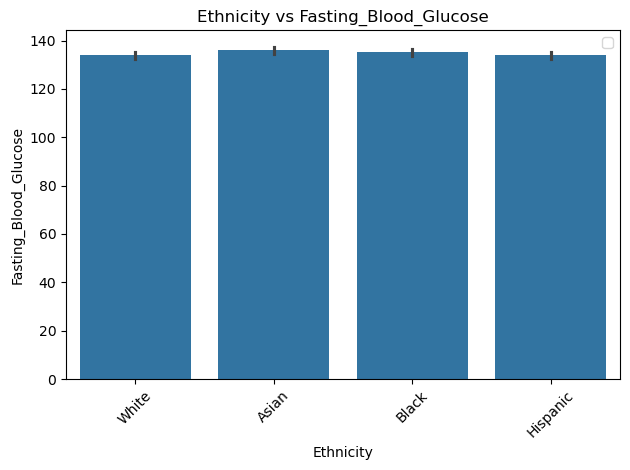

In [197]:
sns.barplot(x=data['Ethnicity'], y= data['Fasting_Blood_Glucose'], data=data)
plt.title('Ethnicity vs Fasting_Blood_Glucose') 
plt.xticks(rotation=45)  
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Jonna\AppData\Local\Temp\ipykernel_12256\707497576.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


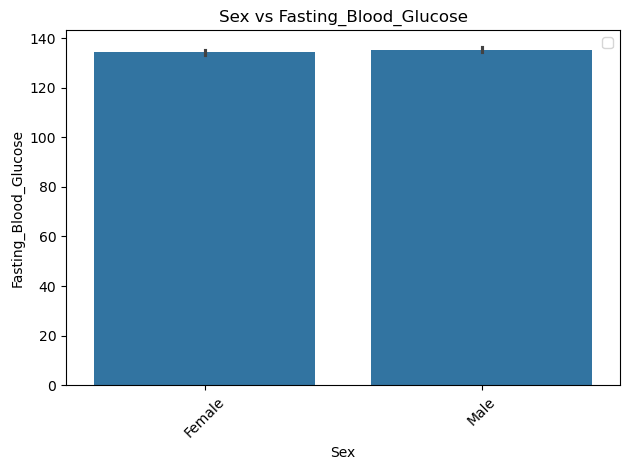

In [198]:
sns.barplot(x=data['Sex'], y= data['Fasting_Blood_Glucose'], data=data)
plt.title('Sex vs Fasting_Blood_Glucose') 
plt.xticks(rotation=45)  
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Jonna\AppData\Local\Temp\ipykernel_27256\542794628.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = data.groupby('Age Group')['Fasting_Blood_Glucose'].mean().reset_index()


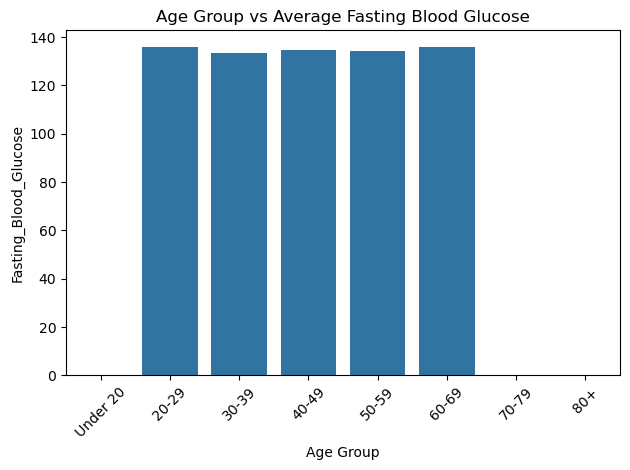

In [70]:
## agrupamiento por rango de edad y calculo del promedio de Fasting_Blood_Glucose
grouped_df = data.groupby('Age Group')['Fasting_Blood_Glucose'].mean().reset_index()

age_order = ['Under 20', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
grouped_df['Age Group'] = pd.Categorical(grouped_df['Age Group'], categories=age_order, ordered=True)
grouped_df = grouped_df.sort_values('Age Group')

sns.barplot(x='Age Group', y='Fasting_Blood_Glucose', data=grouped_df)
plt.title('Age Group vs Average Fasting Blood Glucose')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

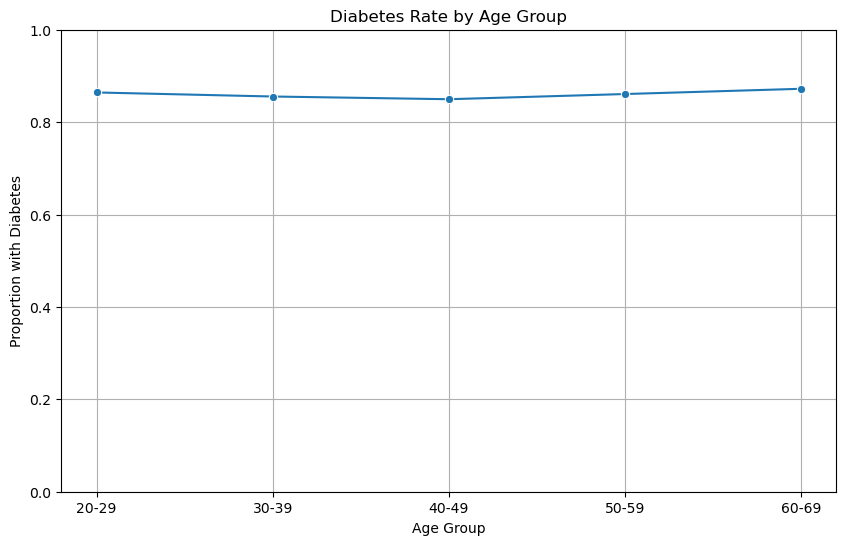

In [50]:
age_group_diabetes = data.groupby('Age Group', observed=True)['Outcome'].mean().reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='Age Group', y='Outcome', data=age_group_diabetes, marker='o', ax=ax)
ax.set_title('Diabetes Rate by Age Group')
ax.set_xlabel('Age Group')
ax.set_ylabel('Proportion with Diabetes')
ax.set_ylim(0, 1)
ax.grid(True)


**Codifcación de Variables**

In [71]:
label_encoders = {}  # Diccionario para guardar codificadores por columna

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le  # Guardar el encoder entrenado para esa columna

In [28]:
## separacion de x y y con todas las variables
df =data.copy()
y = df['Outcome']
X = df.drop('Outcome', axis=1)

In [72]:
## separacion de x y y con variables disponibles
df =data.copy()
y = df['Outcome']
columns_drops = ['Outcome','Fasting_Blood_Glucose', 'HbA1c', 'Cholesterol_Total', 'Cholesterol_HDL', 'Cholesterol_LDL', 'GGT', 'Serum_Urate', 
                       'Dietary_Intake_Calories','Age Group']
X = df.drop(columns=columns_drops, axis=1)


<Figure size 1000x600 with 0 Axes>

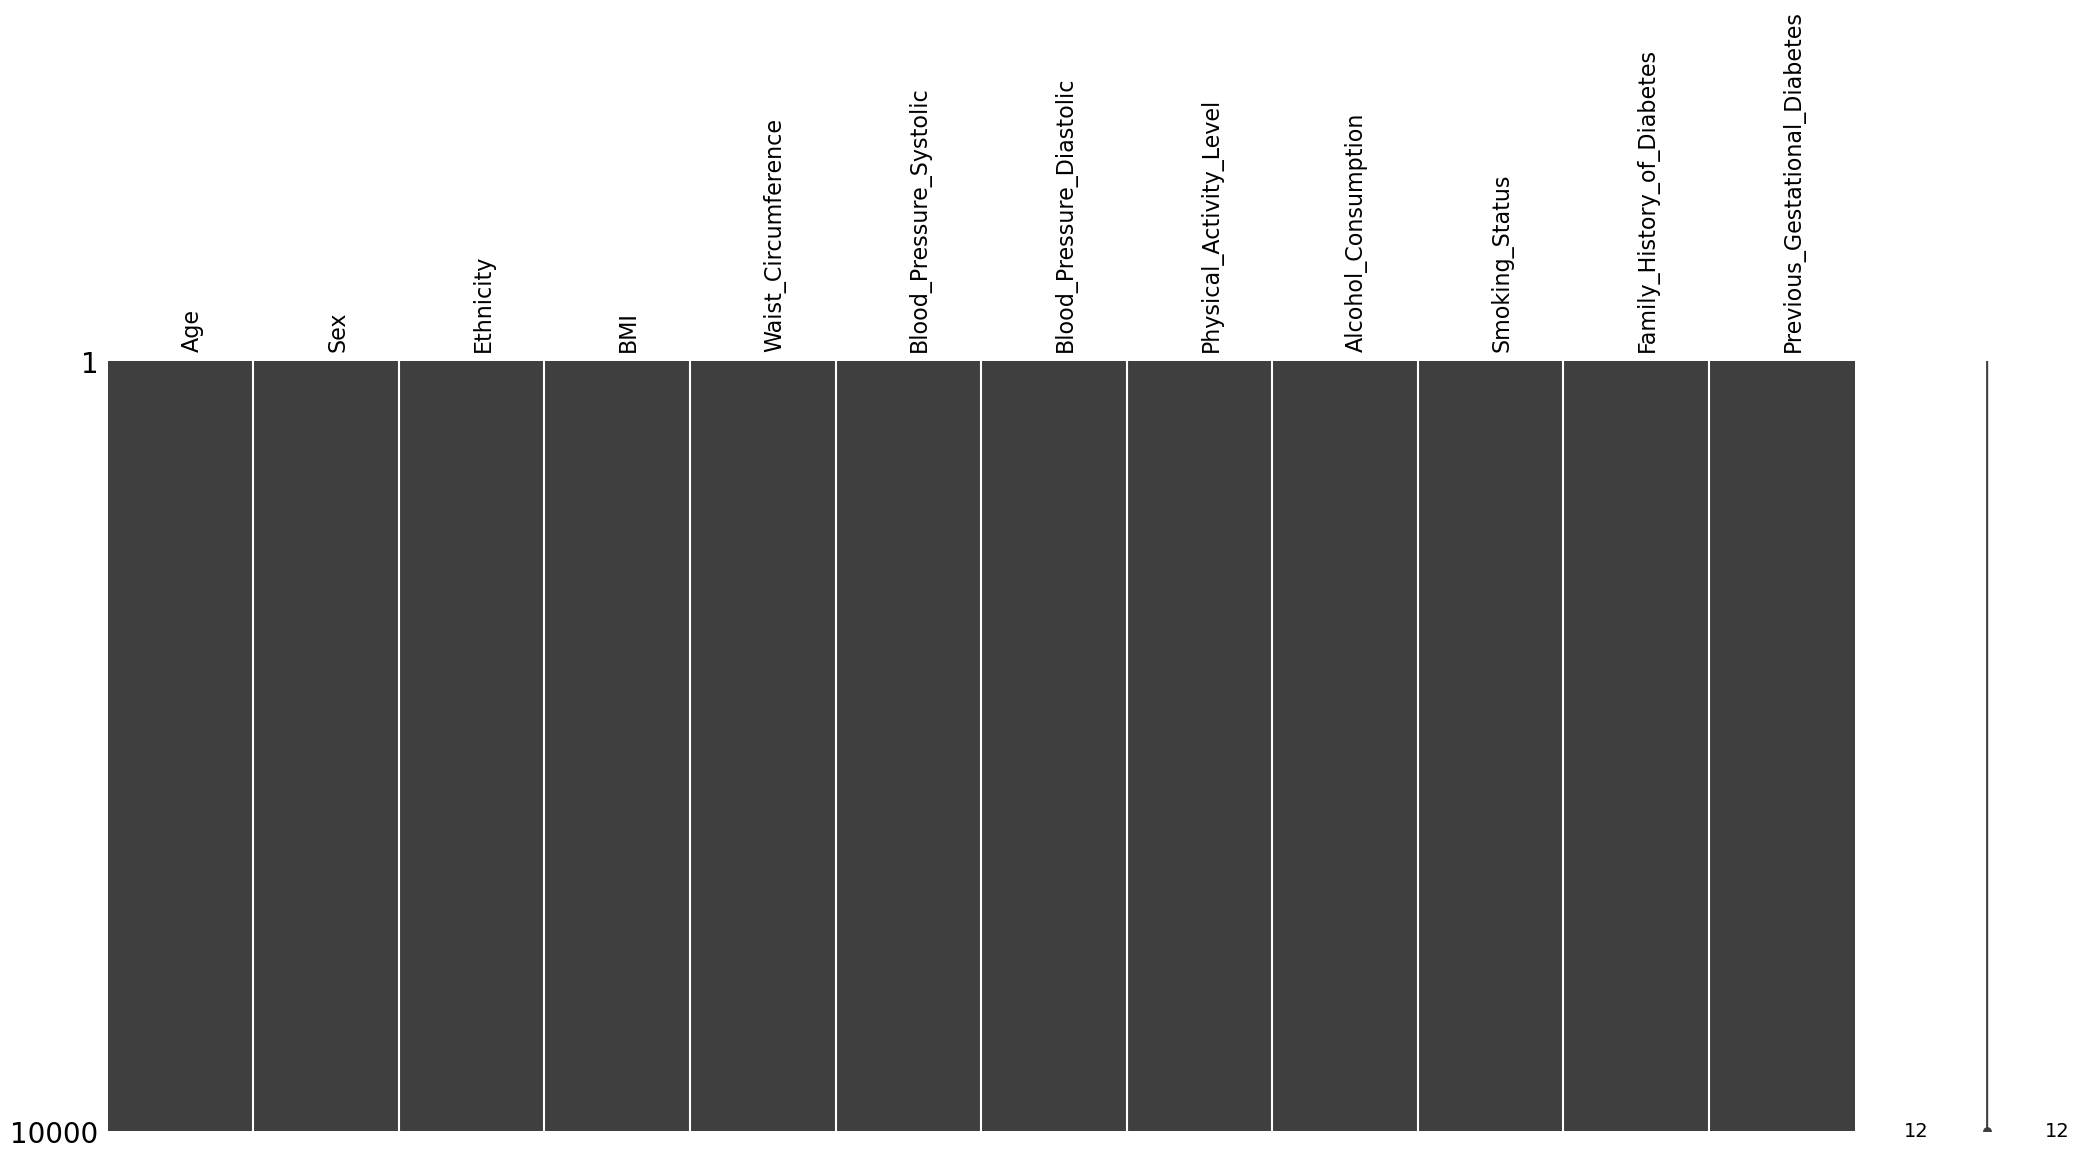

In [73]:
plt.figure(figsize=(10, 6))
msno.matrix(X)
plt.xticks(rotation=90)
plt.show()

**Division de la data**

In [74]:
# División de datos: 80% entrenamiento, 10% validación, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_all_scaled = scaler.fit_transform(X)  


**MODELO SVM**


In [206]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train_scaled, y_train)

SVC()

**MODELO REGRESION LOGISTICA**

In [208]:
# Modelo Regresion Logística
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

**Modelo Arboles de Decision**

In [210]:
# Modelo Arboles de Decisión
from sklearn.tree import DecisionTreeClassifier 
model = DecisionTreeClassifier()
model.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

**Random forest**

In [75]:
# Modelo Random Forest
from sklearn.ensemble import RandomForestClassifier 
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)

RandomForestClassifier()

**Modelo Gb Boost**

In [62]:
# Modelo XGBoost
model = xgb.XGBClassifier()
model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

🔍 VALIDACIÓN
Accuracy: 99.9
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       143
           1       1.00      1.00      1.00       857

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

🧪 TEST
Accuracy: 99.9
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       128
           1       1.00      1.00      1.00       872

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

🔁 Validación Cruzada - Accuracy Promedio: 99.98000000000002
F1 Macro Score Promedio: 0.9993742635645434


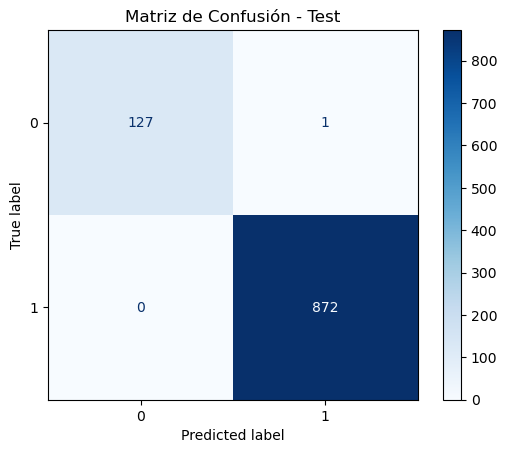

In [76]:
# Validación
y_val_pred = model.predict(X_val_scaled)
print("🔍 VALIDACIÓN")
print("Accuracy:", model.score(X_val_scaled, y_val) * 100)
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# Test
y_test_pred = model.predict(X_test_scaled)
print("🧪 TEST")
print("Accuracy:", model.score(X_test_scaled, y_test) * 100)
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Validación cruzada
acc_scores = cross_val_score(model, X_all_scaled, y, cv=5)
print("🔁 Validación Cruzada - Accuracy Promedio:", np.mean(acc_scores) * 100)

f1_scores = cross_val_score(model, X_all_scaled, y, cv=5, scoring='f1_macro')
print("F1 Macro Score Promedio:", np.mean(f1_scores))

# Matriz de Confusión (test)
cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title("Matriz de Confusión - Test")
plt.show()

In [150]:
# Guardar el modelo entrenado xg boost y los objetos necesarios
joblib.dump(model, 'xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(numeric_cols, 'numeric_cols.pkl')
joblib.dump(categorical_cols, 'categorical_cols.pkl')
joblib.dump(X.columns.tolist(), 'columnas_modelo.pkl')

['columnas_modelo.pkl']

In [77]:
# Guardar el modelo de regresión logística y objetos asociados
joblib.dump(model, 'logreg_model.pkl')  
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(numeric_cols, 'numeric_cols.pkl')
joblib.dump(categorical_cols, 'categorical_cols.pkl')


['categorical_cols.pkl']

In [78]:
# Guardar modelo y objetos
joblib.dump(model, 'rf_model.pkl') 
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(numeric_cols, 'numeric_cols.pkl')
joblib.dump(categorical_cols, 'categorical_cols.pkl')
joblib.dump(X.columns.tolist(), 'columnas_modelo.pkl')

['columnas_modelo.pkl']